In [1]:
import urllib3
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="white", color_codes=True)

urllib3.disable_warnings()

In [2]:
def integrify(s):
    "Converts to integers, but more importantly kills off accidental missparsing."
    try:
        i = int(s.replace(",",""))
        if i < 1000:
            return 0
        return i
    except:
        return 0

# get page with list of cities
http = "https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population"
response = urllib3.PoolManager().request( 'GET', http )
soup = BeautifulSoup(response.data, "lxml")

city_name = []
wiki_page = []
cens_2011 = []
cens_2001 = []

city_name_col = 1
wiki_page_col = 1
cens_2011_col = 2
cens_2001_col = 3

col_max = max(city_name_col,
              wiki_page_col,
              cens_2011_col,
              cens_2001_col)

right_tables = soup.find_all('table', class_="wikitable")

for tab in right_tables: # data split in multiple tables
    for row in tab.find_all("tr"):
        cells = row.find_all("td")
        if len(cells) > col_max: # chuck away headers etc.
            city_name.append(cells[city_name_col].find(text=True))
            cens_2011.append(cells[cens_2011_col].find(text=True))
            cens_2001.append(cells[cens_2001_col].find(text=True))
            wiki_page.append(
                "https://en.wikipedia.org" +
                cells[wiki_page_col].find("a", href=True)["href"])
            

df = pd.DataFrame()
    
df["City name"] = city_name
df["Wiki page"] = wiki_page
df["Census 2011"] = cens_2011
df["Census 2001"] = cens_2001

# drop missparsed cells
df["Census 2011"] = list(map(integrify, df["Census 2011"]))
df["Census 2001"] = list(map(integrify, df["Census 2001"]))
df = df[df["Census 2011"] > 0]
df = df[df["Census 2001"] > 0]

# drop cities with no wiki page
df = df.dropna(axis=1, how='any')
df = df.reset_index()
df.drop("index", 1, inplace=True)

# fix mistake on wikipedia
df.set_value(df["City name"]=="Guna", "Wiki page", "https://en.wikipedia.org/wiki/Guna,_India")

df.head()

,City name,Wiki page,Census 2011,Census 2001
0,Mumbai,https://en.wikipedia.org/wiki/Mumbai,12442373,11978450
1,Delhi,https://en.wikipedia.org/wiki/Delhi,11034555,9879172
2,Bangalore,https://en.wikipedia.org/wiki/Bangalore,8443675,4301326
3,Hyderabad,"https://en.wikipedia.org/wiki/Hyderabad,_India",6731790,3637483
4,Ahmedabad,https://en.wikipedia.org/wiki/Ahmedabad,5577940,3520085


In [3]:
def get_coord(a):
    """Parses coordinates given on wikipedia. Converts degree/minut/second to float degrees"""
    b = a.replace("°", ",").replace("′", ",").replace("″", ",").split(",")
    
    sign = -1 if b[-1] in ["N", "E"] else -1
    sumc = float(b[0]) + float(b[1])/60.
    
    if len(b) == 4:
        sumc += float(b[2])/3600.
 
    return sign * sumc

def get_info(city_page):
    """Given city page obtains coordinates and measures article length."""
    response = urllib3.PoolManager().request( 'GET', city_page )
    soup = BeautifulSoup(response.data, "lxml")
    
    lat = soup.find("span", class_="latitude")
    lon = soup.find("span", class_="longitude")
    
    if lat is not None and lon is not None:
        return get_coord(lat.text), get_coord(lon.text), len(soup.prettify())
    else:
        print("Missing coordinates! Check %s" % city_page)
        return None

In [4]:
%%time

df["Latitude"], df["Longitude"], df["Wiki interest"] = np.array(list(map(get_info, df["Wiki page"]))).transpose()

# Useful for finding smaller, for example historically important cities.
df["Relative interest"] = df["Wiki interest"]/df["Census 2011"]

CPU times: user 1min 14s, sys: 788 ms, total: 1min 14s
Wall time: 3min 47s


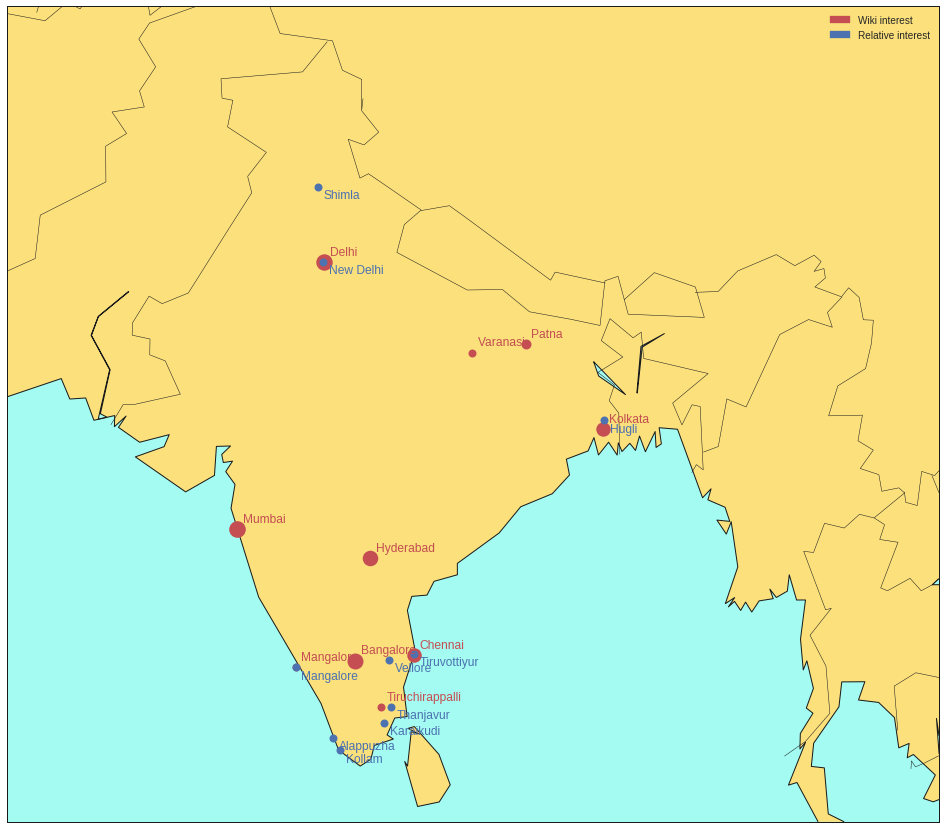

In [5]:
%%capture --no-display
# ^ basemap warnings

from mpl_toolkits.basemap import Basemap, cm
import matplotlib.patches as mpatches

# prep map
plt.figure(figsize=(30,15))
m = Basemap(width=4000000,height=3500000,projection='lcc', resolution='c',lat_1=22.,lat_2=-80,lat_0=23,lon_0=83)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='#a4fbf1')
m.fillcontinents(color="#fbe07c", lake_color='#a4fbf1')

# larger cities get bigger dot
def marker(x):
    return max(18*np.exp(-1e6/x), 8)

# Top 10 wiki interest
for i in (df.sort_values(by=["Wiki interest"], ascending=False).head(n=10)).index:
    x, y = m(-df["Longitude"][i], -df["Latitude"][i])
    m.plot(x, y, 'ro', markersize=marker(df["Census 2011"][i]))
    plt.text(x+25000, y+30000, df["City name"][i], color='r')

# Top 10 relative interest
for i in (df.sort_values(by=["Relative interest"], ascending=False).head(n=10)).index:
    x, y = m(-df["Longitude"][i], -df["Latitude"][i])
    m.plot(x, y, 'bo', markersize=marker(df["Census 2011"][i]))
    plt.text(x+25000, y-50000, df["City name"][i], color='b')


# legend
red_patch = mpatches.Patch(color='r', label='Wiki interest')
blue_patch = mpatches.Patch(color='b', label='Relative interest')
plt.legend(handles=[red_patch, blue_patch])

plt.show()